# Pytorch Diffusion, in this git repo I implement denoising diffusion using only built in Pytorch functionality.

I initally wanted to do my project on text diffusion and compare that to traditional autoregressive text generation. When I read papers on the topic I found it somewhat challenging to understand but easy enough to skip over the challenging parts in favor of a thematic understanding. This made it difficult to dig my heels into the topic, text diffusion is a new concept so there isn't a lot of information available on it. I was hoping that running experiments with it would be relatively simple, but I found that it was not. Most of the difficulties came from not having access to the right hardware or software (the 'standard' text diffusion git repo is newer than my computer can work with) and not having a good understanding of how the diffusion process works. So I thought I should work to understand diffusion better (not use any easy libraries or repos), and switch my project topic to continuous denoising diffusion for images.

I hope that in the future I can apply what I learned doing this project to discrete diffusion for text generation.

100%|██████████| 4996278331/4996278331 [00:56<00:00, 87659750.66it/s]


Extracting ./food-101.tar.gz to .


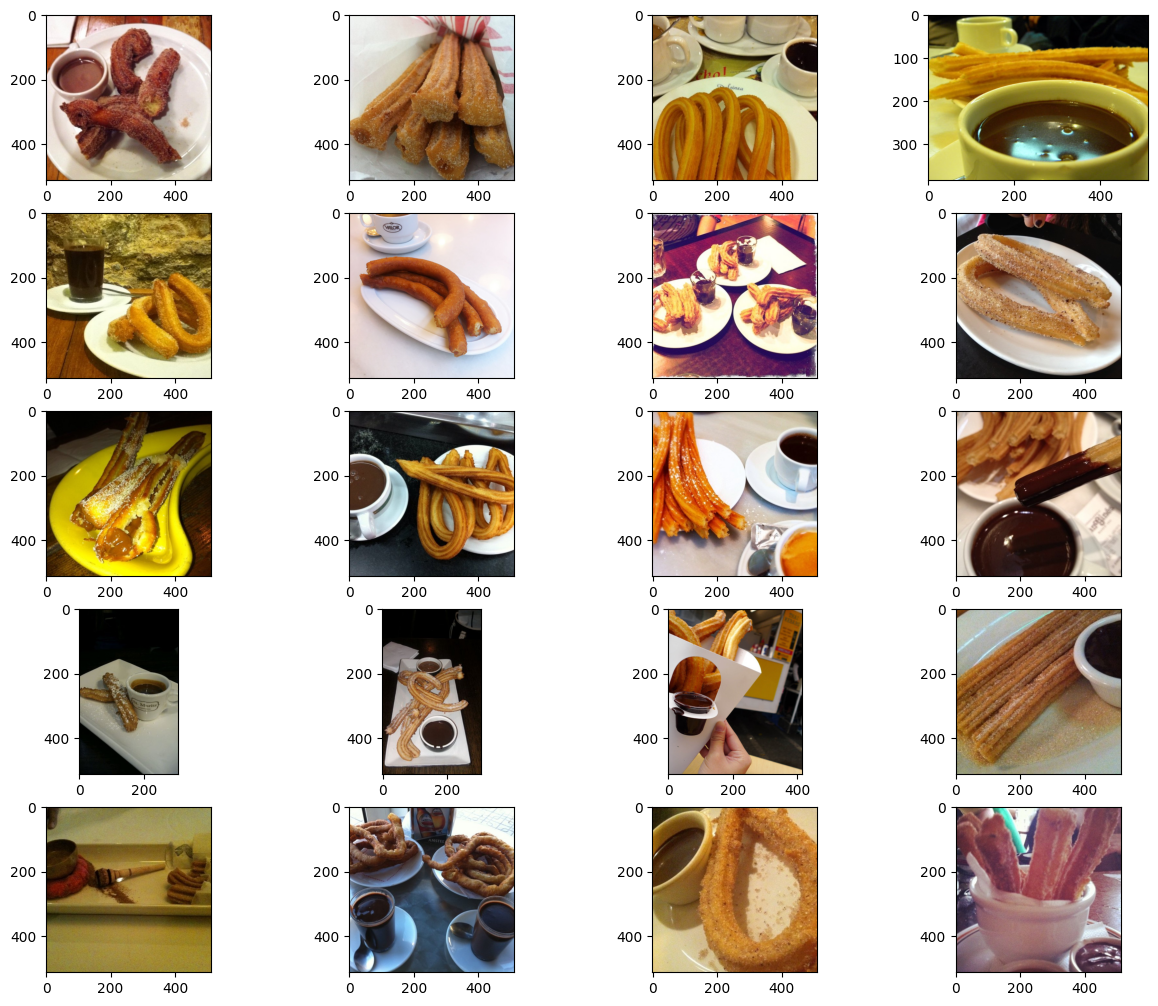

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt

def plot_images(datset, num_samples=20, cols=4):
    plt.figure(figsize=(15,15))
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])

data = torchvision.datasets.Food101(root=".", download=True)
plot_images(data)

Here we define our noising schedules. For simplicity we will use the linear schedule in the ensuing experiment, but cosine and quadrating schedules have shown great results in the literature.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

def quadratic_beta_schedule(timesteps):
    """
    quadratic beta schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    x = torch.linspace(0, timesteps, timesteps + 1)
    alphas_cumprod = 1. - (1. - x / timesteps) ** 2
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


This method is the crux or the process. We use the fact that the sum of a gaussian is itself a gaussian distribution to be able to compute the mean and variance of the noise gaussian at an arbitrary t. We then can sample for this distribution during training. We also precompute the relevant statistics, rather than computing them on the fly, to save computation and time when training our model.

In [ ]:
def forward_diffusion_sample(x_0, t, device='cpu'):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
        + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

# Pre-compute for training to get noise at arbitrary t
T = 200
betas = linear_beta_schedule(T)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)


We set up our dataset and dataloader. Load the data, provide it with our augmentations, and normalize it to [-1, 1]. We scale our images down to 64x64 with a center crop to make training faster/tractable on limited hardware, but this come at the cost of generation quality

In [ ]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np

import matplotlib.pyplot as plt

IMG_SIZE = 64
BATCH_SIZE = 512

def load_transformed_dataset():
  data_transforms = transforms.Compose([
      transforms.Resize((IMG_SIZE, IMG_SIZE)),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Lambda(lambda t: (t * 2) - 1),
  ])

  train = torchvision.datasets.Food101(root='.', download=True, transform=data_transforms)
  test = torchvision.datasets.Food101(root='.', download=True, transform=data_transforms, split='test')

  return torch.utils.data.ConcatDataset([train, test])

def plot_image(image):
  reverse_transforms = transforms.Compose([
      transforms.Lambda(lambda t: (t + 1) / 2),
      transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
      transforms.Lambda(lambda t: t * 255.),
      transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
      transforms.ToPILImage(),
  ])

  if len(image.shape) == 4:
      image = image[0]
  plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Output some samples to see what the noising process looks like. Here we are using the linear schedule for simplicity

<ipython-input-16-aec28afbfe64>:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(i / step_size) + 1)


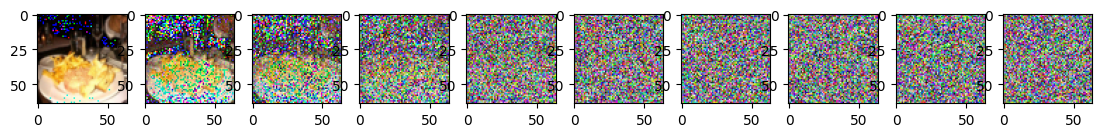

In [ ]:
image = next(iter(dataloader))[0]

plt.figure(figsize=(15, 15))
plt.axis('off')
num_images = 10
step_size = int(T / num_images)

for i in range(0, T, step_size):
  t = torch.Tensor([i]).type(torch.int64)
  plt.subplot(1, num_images+1, int(i / step_size) + 1)
  image, noise = forward_diffusion_sample(image, t)
  plot_image(image)



This is a pretty standard Unet, but with a large capacity (60m parameters) and the ability to process the temporal embeddings. This is essential to the model's quality because we are randomly sampling t during training, and in inference we want to be able to skip iterations to improve generation speed. Without the embedding the model would have no way of knowing what time step in the denoising process it was in.

In [ ]:
!pip install torchinfo
import math
from torchinfo import summary

class Block(nn.Module):
  def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
    super().__init__()
    self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
    if up:
      self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
      self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
    else:
      self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
      self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
    self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
    self.bnorm1 = nn.BatchNorm2d(out_ch)
    self.bnorm2 = nn.BatchNorm2d(out_ch)
    self.relu = nn.ReLU()

  def forward(self, x, t):
    h = self.bnorm1(self.relu(self.conv1(x)))
    time_emb = self.relu(self.time_mlp(t))
    # extend the last 2 dimensions
    time_emb = time_emb[(..., ) + (None, ) * 2]
    h += time_emb
    h = self.bnorm2(self.relu(self.conv2(h)))
    return self.transform(h)

class SinusoidalPositionalEmbeddings(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.dim = dim

  def forward(self, time):
    device = time.device
    half_dim = self.dim // 2
    embeddings = math.log(10000) / (half_dim - 1)
    embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
    embeddings = time[:, None] * embeddings[None, :]
    embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
    return embeddings

class SimpleUnet(nn.Module):
  def __init__(self,
               in_ch=3,
               down_ch=[64, 128, 256, 512, 1024],
               up_ch=[1024, 512, 256, 128, 64],
               out_ch=3,
               time_emb_dim=32):
    super().__init__()

    self.time_mlp = nn.Sequential(
        SinusoidalPositionalEmbeddings(time_emb_dim),
        nn.Linear(time_emb_dim, time_emb_dim),
        nn.ReLU(),
    )

    self.conv0 = nn.Conv2d(in_ch, down_ch[0], 3, padding=1)

    self.downs = nn.ModuleList([Block(down_ch[i], down_ch[i+1], time_emb_dim) for i in range(len(down_ch)-1)])
    self.ups = nn.ModuleList([Block(up_ch[i], up_ch[i+1], time_emb_dim, up=True) for i in range(len(up_ch)-1)])

    self.output = nn.Conv2d(up_ch[-1], out_ch, 1)

  def forward(self, x, t):
    t = self.time_mlp(t)
    x = self.conv0(x)

    res = []
    for down in self.downs:
      x = down(x, t)
      res.append(x)
    for up in self.ups:
      x = torch.cat([x, res.pop()], dim=1)
      x = up(x, t)
    return self.output(x)

model = SimpleUnet()
summary(model)

Layer (type:depth-idx)                             Param #
SimpleUnet                                         --
├─Sequential: 1-1                                  --
│    └─SinusoidalPositionalEmbeddings: 2-1         --
│    └─Linear: 2-2                                 1,056
│    └─ReLU: 2-3                                   --
├─Conv2d: 1-2                                      1,792
├─ModuleList: 1-3                                  --
│    └─Block: 2-4                                  --
│    │    └─Linear: 3-1                            4,224
│    │    └─Conv2d: 3-2                            73,856
│    │    └─Conv2d: 3-3                            262,272
│    │    └─Conv2d: 3-4                            147,584
│    │    └─BatchNorm2d: 3-5                       256
│    │    └─BatchNorm2d: 3-6                       256
│    │    └─ReLU: 3-7                              --
│    └─Block: 2-5                                  --
│    │    └─Linear: 3-8                            8

We use a simple L1 loss, L2 and other losses can also be used. Only using L2 has the disadvantage of generating images that blurred/smoothed because of the averaging quality

In [ ]:
def get_loss(model, x0, t):
  x_noise, noise = forward_diffusion_sample(x0, t, device)
  x_pred = model(x_noise, t)
  return F.l1_loss(noise, x_pred)

Here we set up code for sampling the noise at a given timestep, along with a method for visualizing the model's output

In [ ]:
@torch.no_grad()
def sample_timestep(x, t):
  betas_t = get_index_from_list(betas, t, x.shape)
  sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
      sqrt_one_minus_alphas_cumprod, t, x.shape)
  sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

  model_mean = sqrt_recip_alphas_t * (
      x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t)
  posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

  if t == 0:
    return model_mean
  else:
    noise = torch.randn_like(x)
    return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def plot_sample_images():
  img = torch.randn((1, 3, IMG_SIZE, IMG_SIZE), device=device)
  plt.figure(figsize=(15, 15))
  plt.axis('off')
  num_Images = 10
  step_size = int(T / num_images)

  for i in range(T)[::-1]:
    t = torch.full((1,), i, device=device, dtype=torch.long)
    img = torch.clamp(sample_timestep(img, t), -1., 1)

    if i % step_size == 0:
      plt.subplot(1, num_images, int(i // step_size) + 1)
      plot_image(img.detach().cpu())
  plt.show()

Here we finally train our network, printing the loss and generated examples occasionally for monitoring. We also save out the model each time we improve the loss.

In [ ]:
from torch.optim import Adam, AdamW

from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SimpleUnet().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
epochs = 400

best_loss = 1e9
for epoch in range(epochs):
  losses = []
  for i, batch in enumerate(tqdm(dataloader, desc=f'Training {epoch}')):
    optimizer.zero_grad()

    t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
    loss = get_loss(model, batch[0], t)

    losses.append(loss.item())
    loss.backward()
    optimizer.step()

    if i % 40 == 0:
      print(f'Epoch [{epoch}] batch: {i} loss: {loss.item():1.4f}')
      plot_sample_images()
  print(f'Epoch [{epoch}] loss: {np.mean(losses)}')
  if np.mean(losses) < best_loss:
    print('Saving new best model')
    best_loss = np.mean(losses)
    torch.save(model.state_dict(), 'best_model.pth')

Further work: Experiments with a transformer based Unet. In the literature and large production models the transformer is the standard architectural choice for diffusion models, over convolutions. Favored for their long range connections. This implementation specifically (DiT based) is interesting because it argues the long range skip connections between layers are the critical component to high quality, rather than the down and upsampling of traditional Unets.

In [ ]:
!pip install timm
!pip install einops

import torch
import torch.nn as nn
import math
from .timm import trunc_normal_, Mlp
import einops
import torch.utils.checkpoint

if hasattr(torch.nn.functional, 'scaled_dot_product_attention'):
    ATTENTION_MODE = 'flash'
else:
    try:
        import xformers
        import xformers.ops
        ATTENTION_MODE = 'xformers'
    except:
        ATTENTION_MODE = 'math'
print(f'attention mode is {ATTENTION_MODE}')


def timestep_embedding(timesteps, dim, max_period=10000):
    """
    Create sinusoidal timestep embeddings.

    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


def patchify(imgs, patch_size):
    x = einops.rearrange(imgs, 'B C (h p1) (w p2) -> B (h w) (p1 p2 C)', p1=patch_size, p2=patch_size)
    return x


def unpatchify(x, channels=3):
    patch_size = int((x.shape[2] // channels) ** 0.5)
    h = w = int(x.shape[1] ** .5)
    assert h * w == x.shape[1] and patch_size ** 2 * channels == x.shape[2]
    x = einops.rearrange(x, 'B (h w) (p1 p2 C) -> B C (h p1) (w p2)', h=h, p1=patch_size, p2=patch_size)
    return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, L, C = x.shape

        qkv = self.qkv(x)
        if ATTENTION_MODE == 'flash':
            qkv = einops.rearrange(qkv, 'B L (K H D) -> K B H L D', K=3, H=self.num_heads).float()
            q, k, v = qkv[0], qkv[1], qkv[2]  # B H L D
            x = torch.nn.functional.scaled_dot_product_attention(q, k, v)
            x = einops.rearrange(x, 'B H L D -> B L (H D)')
        elif ATTENTION_MODE == 'xformers':
            qkv = einops.rearrange(qkv, 'B L (K H D) -> K B L H D', K=3, H=self.num_heads)
            q, k, v = qkv[0], qkv[1], qkv[2]  # B L H D
            x = xformers.ops.memory_efficient_attention(q, k, v)
            x = einops.rearrange(x, 'B L H D -> B L (H D)', H=self.num_heads)
        elif ATTENTION_MODE == 'math':
            qkv = einops.rearrange(qkv, 'B L (K H D) -> K B H L D', K=3, H=self.num_heads)
            q, k, v = qkv[0], qkv[1], qkv[2]  # B H L D
            attn = (q @ k.transpose(-2, -1)) * self.scale
            attn = attn.softmax(dim=-1)
            attn = self.attn_drop(attn)
            x = (attn @ v).transpose(1, 2).reshape(B, L, C)
        else:
            raise NotImplemented

        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm, skip=False, use_checkpoint=False):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale)
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer)
        self.skip_linear = nn.Linear(2 * dim, dim) if skip else None
        self.use_checkpoint = use_checkpoint

    def forward(self, x, skip=None):
        if self.use_checkpoint:
            return torch.utils.checkpoint.checkpoint(self._forward, x, skip)
        else:
            return self._forward(x, skip)

    def _forward(self, x, skip=None):
        if self.skip_linear is not None:
            x = self.skip_linear(torch.cat([x, skip], dim=-1))
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, patch_size, in_chans=3, embed_dim=768):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        assert H % self.patch_size == 0 and W % self.patch_size == 0
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x


class UViT(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.,
                 qkv_bias=False, qk_scale=None, norm_layer=nn.LayerNorm, mlp_time_embed=False, num_classes=-1,
                 use_checkpoint=False, conv=True, skip=True):
        super().__init__()
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.num_classes = num_classes
        self.in_chans = in_chans

        self.patch_embed = PatchEmbed(patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = (img_size // patch_size) ** 2

        self.time_embed = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.SiLU(),
            nn.Linear(4 * embed_dim, embed_dim),
        ) if mlp_time_embed else nn.Identity()

        if self.num_classes > 0:
            self.label_emb = nn.Embedding(self.num_classes, embed_dim)
            self.extras = 2
        else:
            self.extras = 1

        self.pos_embed = nn.Parameter(torch.zeros(1, self.extras + num_patches, embed_dim))

        self.in_blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                norm_layer=norm_layer, use_checkpoint=use_checkpoint)
            for _ in range(depth // 2)])

        self.mid_block = Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                norm_layer=norm_layer, use_checkpoint=use_checkpoint)

        self.out_blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                norm_layer=norm_layer, skip=skip, use_checkpoint=use_checkpoint)
            for _ in range(depth // 2)])

        self.norm = norm_layer(embed_dim)
        self.patch_dim = patch_size ** 2 * in_chans
        self.decoder_pred = nn.Linear(embed_dim, self.patch_dim, bias=True)
        self.final_layer = nn.Conv2d(self.in_chans, self.in_chans, 3, padding=1) if conv else nn.Identity()

        trunc_normal_(self.pos_embed, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed'}

    def forward(self, x, timesteps, y=None):
        x = self.patch_embed(x)
        B, L, D = x.shape

        time_token = self.time_embed(timestep_embedding(timesteps, self.embed_dim))
        time_token = time_token.unsqueeze(dim=1)
        x = torch.cat((time_token, x), dim=1)
        if y is not None:
            label_emb = self.label_emb(y)
            label_emb = label_emb.unsqueeze(dim=1)
            x = torch.cat((label_emb, x), dim=1)
        x = x + self.pos_embed

        skips = []
        for blk in self.in_blocks:
            x = blk(x)
            skips.append(x)

        x = self.mid_block(x)

        for blk in self.out_blocks:
            x = blk(x, skips.pop())

        x = self.norm(x)
        x = self.decoder_pred(x)
        assert x.size(1) == self.extras + L
        x = x[:, self.extras:, :]
        x = unpatchify(x, self.in_chans)
        x = self.final_layer(x)
        return x